<a href="https://colab.research.google.com/github/DT6A/Captioning/blob/master/Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Image Captioning </h1>


![img](https://i.imgur.com/obITaMl.png)

## Base:

### 1. Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import glob

#glob.os.chdir('../../')
os.listdir()

['.config', 'gdrive', 'sample_data']

In [0]:
!cd .. ;dir

My\ Drive


In [0]:
!mkdir Data

In [0]:
!tar -C Data -xvf gdrive/My\ Drive/handout.tar

data/
data/captions_tokenized.json
data/image_codes.npy


In [0]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("Data/data/image_codes.npy")
captions = json.load(open('Data/data/captions_tokenized.json'))

In [0]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [0]:
np.mean([len(c.split()) for c in np.array(captions).reshape(-1)])

11.292223152163805

In [0]:
words = {}

for caps in captions:
  for c in caps:
    for w in c.split():
      if w in words:
        words[w] += 1
      else:
        words[w] = 1

In [0]:
sort_words = sorted(list(words.items()), key=lambda x: x[1], reverse=True)

In [0]:
next_id = 3
w2n = {'BEGIN': 1, 'END': 2, 'PAD': 0}
n2w = {0: 'PAD', 1: 'BEGIN', 2: 'END'}

for w in sort_words:
  if w[1] <= 5:
    break
  w2n[w[0]] = next_id
  n2w[next_id] = w[0]
  next_id += 1

In [0]:
MAX_LEN = 15 + 2

def caption2n(cap):
  cap_s = cap.split()
  ncap = [w2n['BEGIN']]
  for i in range(min(MAX_LEN - 2, len(cap_s))):
    if cap_s[i] in w2n:
      ncap.append(w2n[cap_s[i]])
  ncap.append(w2n['END'])
  while len(ncap) < MAX_LEN:
    ncap.append(w2n['PAD'])
  return ncap

def series_caption2n(caps):
  ser = []
  for c in caps:
    ser.append(caption2n(c))
  return ser

enc_captions = [series_caption2n(cps) for cps in captions]

In [0]:
enc_captions

[[[1, 20, 1025, 8, 15, 133, 490, 80, 210, 4, 2, 0, 0, 0, 0, 0, 0],
  [1, 15, 133, 490, 221, 6, 20, 10, 1904, 6, 210, 4, 2, 0, 0, 0, 0],
  [1, 20, 21, 1025, 18, 15, 133, 125, 1002, 490, 4, 2, 0, 0, 0, 0, 0],
  [1, 29, 1904, 6, 419, 10, 735, 18, 3, 673, 445, 490, 4, 2, 0, 0, 0],
  [1, 20, 636, 80, 210, 376, 419, 10, 735, 18, 15, 133, 125, 490, 4, 2, 0]],
 [[1, 3, 31, 247, 33, 3, 1246, 226, 2, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 3, 31, 247, 33, 3, 1246, 248, 226, 4, 2, 0, 0, 0, 0, 0, 0],
  [1, 3, 31, 5, 75, 160, 275, 33, 3, 1246, 234, 4, 2, 0, 0, 0, 0],
  [1, 3, 358, 11, 247, 33, 3, 33, 226, 234, 4, 2, 0, 0, 0, 0, 0],
  [1, 3, 358, 11, 383, 228, 5, 3, 142, 1246, 234, 4, 2, 0, 0, 0, 0]],
 [[1, 7, 43, 10, 23, 47, 166, 40, 3, 31, 27, 3, 117, 4, 2, 0, 0],
  [1, 3, 47, 11, 74, 18, 3, 61, 117, 4, 2, 0, 0, 0, 0, 0, 0],
  [1, 3, 47, 597, 3, 31, 317, 11, 27, 3, 117, 4, 2, 0, 0, 0, 0],
  [1, 3, 47, 74, 18, 3, 12, 27, 3, 117, 9, 190, 47, 96, 33, 4, 2],
  [1, 3, 78, 6, 291, 28, 21, 8, 3, 213, 37, 2, 0, 0,

In [0]:
from sklearn.model_selection import train_test_split
#captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, np.array(enc_captions),
                                                                                test_size=0.1,
                                                                                random_state=42)

### 2. RNN for captions


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
VOC_SIZE = len(w2n)
n_tokens = VOC_SIZE

In [0]:
from keras.layers import Dense, Dropout, Input, Embedding, LSTM, add, Concatenate
from keras.models import Model

Using TensorFlow backend.


In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(VOC_SIZE, 128, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = Concatenate()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOC_SIZE, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

W0623 14:34:20.929461 139960331454336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 14:34:20.947697 139960331454336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 14:34:20.953070 139960331454336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0623 14:34:20.963052 139960331454336 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

W0623 14:34:21.827121 139960331454336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0623 14:34:21.856858 139960331454336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# batch generator
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
  while True:
    X_img = []
    X_seq = []
    y = []
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    #get images
    batch_images = img_codes[random_image_ix]
  
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
  
   
    
    for idx in range(len(batch_images)):
      for cap in captions_for_batch_images[idx]:
        for i in range(1, MAX_LEN):
          X_img.append(batch_images[idx])
        #print(idx)
          cur_seq = list(cap[:i])
          next_seq = cap[i]
          for j in range(i, MAX_LEN):
            cur_seq.append(w2n['PAD'])
          vec = np.zeros(VOC_SIZE)
          vec[next_seq] = 1
          X_seq.append(cur_seq)
          y.append(vec)
   
    yield  [[np.array(X_img), np.array(X_seq)], np.array(y)]

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      1217280     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

## Train

In [0]:
epochs = 10
number_pics_per_bath = 64
steps = len(train_img_codes)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = generate_batch(train_img_codes, train_captions, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1663/1663 [==============================] - 243s 146ms/step - loss: 2.7590
Epoch 1/1
1663/1663 [==============================] - 234s 141ms/step - loss: 2.2023
Epoch 1/1
1663/1663 [==============================] - 235s 141ms/step - loss: 2.0635
Epoch 1/1
1663/1663 [==============================] - 235s 141ms/step - loss: 2.0004
Epoch 1/1
1663/1663 [==============================] - 235s 142ms/step - loss: 1.9561
Epoch 1/1
1663/1663 [==============================] - 234s 141ms/step - loss: 1.9257
Epoch 1/1
1663/1663 [==============================] - 235s 141ms/step - loss: 1.9010
Epoch 1/1
1663/1663 [==============================] - 234s 141ms/step - loss: 1.8869
Epoch 1/1
1663/1663 [==============================] - 234s 141ms/step - loss: 1.8749
Epoch 1/1
1663/1663 [==============================] - 234s 141ms/step - loss: 1.8604


In [0]:
model.optimizer.lr = 1e-5
for i in range(epochs):
    generator = generate_batch(train_img_codes, train_captions, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1663/1663 [==============================] - 903s 543ms/step - loss: 1.7798
Epoch 1/1
1663/1663 [==============================] - 895s 538ms/step - loss: 1.7615
Epoch 1/1
  15/1663 [..............................] - ETA: 16:11 - loss: 1.7636

KeyboardInterrupt: ignored

In [0]:
from keras.models import load_model

model = load_model('Mlast.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Inseption


In [0]:
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications.inception_v3 import *
import numpy as np

In [0]:
incep = InceptionV3(include_top=False, weights='imagenet')

In [0]:
incep.summary()

In [0]:
!git clone beheaded_inception3.py

Cloning into 'dl_labs'...
remote: Enumerating objects: 271, done.
remote: Total 271 (delta 0), reused 0 (delta 0), pack-reused 271
Receiving objects: 100% (271/271), 4.92 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [0]:
# загружаем inseption
from dl_labs.beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

In [0]:
#from torchvision.models import inception_v3

In [0]:
#inception = inception_v3(pretrained=True).train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:07<00:00, 14450438.68it/s]


In [0]:
inception.parameters

### Generating caption

In [0]:
import tensorflow as tf

In [0]:
def generate_caption(image, caption_prefix=("BEGIN",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)
        vectors_neck = vectors_neck.numpy()
        for _ in range(MAX_LEN):
            # представить в виде матрицы
            prefix_ix = [w2n[w] for w in caption_prefix]
            while len(prefix_ix) < MAX_LEN:
              prefix_ix.append(w2n['PAD'])
            prefix_ix = np.array(prefix_ix)
           
            next_word_probs = model.predict([vectors_neck, np.array([prefix_ix])])[0]

          
            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

           
            if sample:
                next_word = np.random.choice(np.array(list(n2w.items()))[:, 1], p=next_word_probs) 
            else:
                next_word = n2w[np.argmax(next_word_probs)]


            caption_prefix.append(next_word)

            if next_word == "END":
                break
            
    return caption_prefix

### TEST:

In [0]:
import torch

In [0]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

--2019-06-23 16:16:21--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.184.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.184.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105.40K  --.-KB/s    in 0.03s   

2019-06-23 16:16:21 (3.49 MB/s) - ‘img.jpg’ saved [107928/107928]



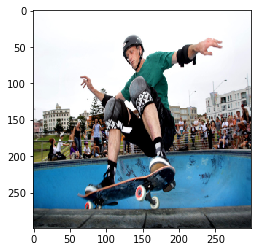

In [0]:
plt.imshow(img)

In [0]:
for i in range(10):
    print(' '.join(generate_caption(img, t=1)[1:-1]))

a boy is on a skateboard
this girl is jumping up in the air on a skateboard .
a man doing a trick in a skateboard outside and is on the skateboard .
a man in a yellow t-shirt on a skate board
a boy riding his skateboard down the ramp .
a skateboarder jumps over a pipe as he stands over his board .
a skateboarder rides outside on a skateboard ramp .
young man grinding his skateboard over railing in the air .
a man in a skate park bending down to go a skateboard .
the man rides the skateboard does his skateboard off up


In [0]:
generate_caption(img, t=5.)

array([[0.42717108, 0.1713015 , 0.12120122, ..., 0.17253105, 0.0696179 ,
        0.41819456]], dtype=float32)

In [0]:
train_img_codes[0]

numpy.ndarray

--2019-06-23 16:42:59--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.03s   

2019-06-23 16:42:59 (3.35 MB/s) - ‘img.jpg’ saved [106870/106870]



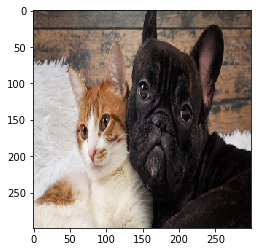

a cat laying on a couch next to a person .
a cat laying on a bed next to a black and white cat .
a cat laying on a couch on the floor .
a cat is sitting on a bed next to a small dog .
a cat is sitting on a bed in a living room .
a cat laying on top of a green couch .
a cat is laying on a bed in a living room .
a cat is sitting on a wooden chair .
a cat is sitting on a bed with a cat .
a cat that is laying on a rug .


In [0]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

In [0]:
import pickle

In [0]:
pickle_out = open('w2n.pkl','wb')
pickle.dump(w2n, pickle_out)
pickle_out.close()

pickle_out = open('n2w.pkl','wb')
pickle.dump(n2w, pickle_out)
pickle_out.close()

#DEMO

--2019-06-23 16:45:13--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS_VrTOhGk4aM_lihdAbCIBCfkFXnVc5_m9KZPjCZz5MtuHIQA_
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.214.139, 172.217.214.101, 172.217.214.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.214.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5980 (5.8K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]   5.84K  --.-KB/s    in 0s      

2019-06-23 16:45:13 (77.6 MB/s) - ‘img.jpg’ saved [5980/5980]



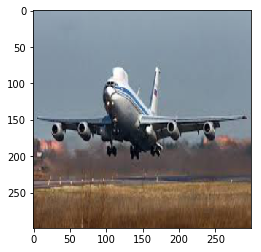

a large airplane is parked on the tarmac .
a large plane is sitting on the tarmac .
a plane is flying in the air on a runway .
a large airplane is sitting on the tarmac .
a plane sitting on the runway with a propeller plane on it .
a large airplane is flying in the air .
a plane is sitting on the tarmac at an airport .
a large jetliner sitting on top of an airport runway .
a large airplane is parked on the runway .
a large jet airplane is parked in a parking lot .


In [0]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS_VrTOhGk4aM_lihdAbCIBCfkFXnVc5_m9KZPjCZz5MtuHIQA_ -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

--2019-06-23 16:43:21--  https://cs8.pikabu.ru/post_img/big/2016/09/18/10/1474217898130655254.jpg
Resolving cs8.pikabu.ru (cs8.pikabu.ru)... 46.229.162.167
Connecting to cs8.pikabu.ru (cs8.pikabu.ru)|46.229.162.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184555 (180K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 180.23K  --.-KB/s    in 0.07s   

2019-06-23 16:43:21 (2.36 MB/s) - ‘img.jpg’ saved [184555/184555]



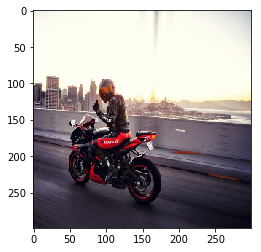

a man riding a motorcycle on a road .
a man riding a motorcycle down a road .
a man on a motorcycle with a helmet on his back .
a man sitting on a motorcycle next to a parked motorcycle .
a man sitting on a motorcycle in the street
a man riding a motorcycle down a street next to a car .
a man on a motorcycle with a helmet on his back .
a man riding a motorcycle down a road .
a person on a motorcycle riding a motorcycle
a man is riding a motorcycle down a street .


In [0]:
!wget https://cs8.pikabu.ru/post_img/big/2016/09/18/10/1474217898130655254.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

--2019-06-23 16:59:08--  https://i.gzn.jp/img/2019/06/18/boston-dynamics-robot-uprising/00.jpg
Resolving i.gzn.jp (i.gzn.jp)... 61.205.12.165, 144.217.39.164, 13.249.146.75, ...
Connecting to i.gzn.jp (i.gzn.jp)|61.205.12.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74882 (73K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  73.13K   276KB/s    in 0.3s    

2019-06-23 16:59:09 (276 KB/s) - ‘img.jpg’ saved [74882/74882]



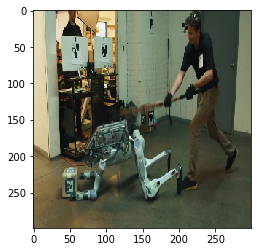

a man holding a tennis racquet on top of a tennis court .
a man holding a tennis racquet on top of a tennis court .
a man holding a tennis racquet on top of a tennis court .
a man in a red shirt and a hat is playing with a frisbee
a man holding a tennis racquet on a tennis court .
a man holding a tennis racquet on a tennis court .
a man holding a tennis racket on a court .
a man holding a tennis racket standing next to a fence .
a man holding a tennis racquet on a tennis court .
a man in a white shirt and a red tie


In [0]:
!wget https://i.gzn.jp/img/2019/06/18/boston-dynamics-robot-uprising/00.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

--2019-06-23 16:49:44--  https://avatarko.ru/img/kartinka/1/siluet_muzhchina_loshad.jpg
Resolving avatarko.ru (avatarko.ru)... 194.67.196.18
Connecting to avatarko.ru (avatarko.ru)|194.67.196.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92989 (91K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  90.81K  --.-KB/s    in 0.1s    

2019-06-23 16:49:46 (637 KB/s) - ‘img.jpg’ saved [92989/92989]



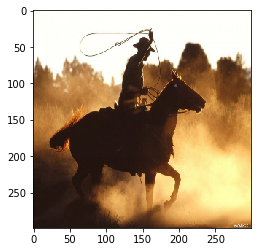

a man is riding a horse on a beach .
a man riding a horse on top of a snow covered field .
a man riding a horse on a snow covered field .
a man riding a horse on a snow covered field .
a man on a horse in the air .
a man riding a horse on a ramp .
a man riding a horse on top of a snow covered field .
a man riding a horse in a park .
a person in a wheelchair with a frisbee in the background
a person that is on a horse on the beach


In [0]:
!wget https://avatarko.ru/img/kartinka/1/siluet_muzhchina_loshad.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

--2019-06-23 16:54:53--  https://83.img.avito.st/640x480/4343019983.jpg
Resolving 83.img.avito.st (83.img.avito.st)... 104.17.58.8, 104.17.59.8
Connecting to 83.img.avito.st (83.img.avito.st)|104.17.58.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64201 (63K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  62.70K  --.-KB/s    in 0.01s   

2019-06-23 16:54:55 (6.08 MB/s) - ‘img.jpg’ saved [64201/64201]



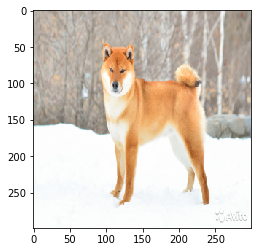

a dog is laying on a bench with a dog on it .
a dog is sitting on a bench near a fence .
a dog is sitting on the ground with a dog .
a dog is sitting on a bench in the snow .
a dog is sitting on a bench next to a dog .
a dog is sitting on a bench next to a dog .
a dog is standing on a bench with a dog on the back .
a dog is sitting on a bench in the middle of a car .
a dog is sitting on a bench in the snow .
a dog is sitting on a bench in the snow .


In [0]:
!wget https://83.img.avito.st/640x480/4343019983.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-06-23 16:35:45--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5amjauLhXerusWTYwS_-mS641--my_wQibceslp5PGbzW3aU6
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 64.233.191.100, 64.233.191.138, 64.233.191.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|64.233.191.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4719 (4.6K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]   4.61K  --.-KB/s    in 0s      

2019-06-23 16:35:45 (58.3 MB/s) - ‘img.jpg’ saved [4719/4719]



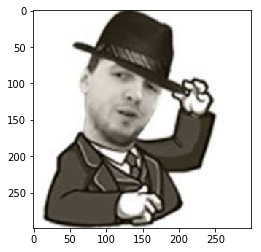

a man with a beard and a tie on
a man wearing a tie and a tie .
a man with a beard and tie standing in front of a building .
a man in a suit and tie is holding a baseball bat .
a man in a suit and tie standing in a room .
a man wearing a tie and a tie .
a man wearing a hat and tie with a tie on .
a man in a suit and tie standing next to a man .
a man wearing a suit and tie with a tie on .
a man wearing a hat and a tie .


In [0]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5amjauLhXerusWTYwS_-mS641--my_wQibceslp5PGbzW3aU6 -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-06-23 16:35:02--  https://lastfm-img2.akamaized.net/i/u/avatar300s/3d70d63c95505c0e131993a2a7536431.jpg
Resolving lastfm-img2.akamaized.net (lastfm-img2.akamaized.net)... 23.215.104.226, 23.215.104.176
Connecting to lastfm-img2.akamaized.net (lastfm-img2.akamaized.net)|23.215.104.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13822 (13K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  13.50K  --.-KB/s    in 0s      

2019-06-23 16:35:02 (262 MB/s) - ‘img.jpg’ saved [13822/13822]



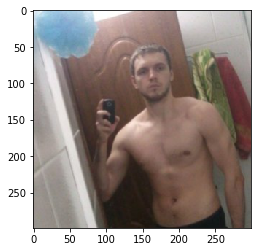

a woman is sitting on a toilet in a bathroom .
a woman is holding a toothbrush in her hand .
a woman is sitting in a chair with a dog .
a woman is sitting on a toilet in a bathroom .
a woman is sitting on a toilet in a bathroom .
a man in a red shirt and black tie
a man in a white shirt and a black shirt
a woman in a red shirt is playing with a wiimote
a woman is sitting on a toilet with a dog .
a woman is taking a selfie in a mirror .


In [0]:
# apply your network on images you've found
#
#
!wget https://lastfm-img2.akamaized.net/i/u/avatar300s/3d70d63c95505c0e131993a2a7536431.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)) / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))